# LGBM을 활용한 베이스라인

In [2]:
import pandas as pd
import os
import random

## 1. 데이터 로딩

In [111]:
data_dir = '/opt/ml/input/data/' # 경로는 상황에 맞춰서 수정해주세요!
csv_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
df = pd.read_csv(csv_file_path) 

## 2. Feature Engineering

In [112]:
def feature_engineering(df):
    
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['hour'] = df['Timestamp'].dt.hour
    diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
    diff = diff.fillna(pd.Timedelta(seconds=0))
    diff = diff['Timestamp'].apply(lambda x: x.total_seconds())
    df['elapsed'] = diff
    
    df['bigcat'] = df['testId'].str[2]
    df['bigcat'] = df['bigcat'].astype('category')
    
    df['smallcat'] = df['testId'].str[7:10]
    df['smallcat'] = df['smallcat'].astype('category')
    sc2idx = {v:k for k,v in enumerate(df['smallcat'].unique())}
    df['smallcat'] = df['smallcat'].map(sc2idx)

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']
    correct_q = df.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum'])
    correct_q.columns = ["q_mean", 'q_sum']

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    df = pd.merge(df, correct_q, on=['assessmentItemID'], how="left")
    
    return df

In [113]:
df = feature_engineering(df)
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,hour,elapsed,bigcat,smallcat,test_mean,test_sum,tag_mean,tag_sum,q_mean,q_sum
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,0,0.0,6,0,0.947683,1268,0.955022,637,0.982063,219
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.0,0,3.0,6,0,0.947683,1268,0.913187,3040,0.964126,215
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2.0,2,1.0,0,8.0,6,0,0.947683,1268,0.913187,3040,0.910314,203
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3.0,3,1.0,0,7.0,6,0,0.947683,1268,0.913187,3040,0.968610,216
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4.0,4,1.0,0,7.0,6,0,0.947683,1268,0.913187,3040,0.941704,210


## 3. Train/Test 데이터 셋 분리

In [114]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [115]:
train

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,hour,elapsed,bigcat,smallcat,test_mean,test_sum,tag_mean,tag_sum,q_mean,q_sum
745,1,A040013001,A040000013,2020-01-06 08:40:43,2048,NaN,0,NaN,8,0.0,4,86,0.595472,789,0.616900,971,0.800000,212
746,1,A040013002,A040000013,2020-01-06 08:43:46,2048,1.0,1,1.000000,8,183.0,4,86,0.595472,789,0.616900,971,0.615094,163
747,1,A040013003,A040000013,2020-01-06 08:44:29,2047,2.0,2,1.000000,8,43.0,4,86,0.595472,789,0.570962,1050,0.781132,207
748,1,A040013004,A040000013,2020-01-06 08:46:13,2047,3.0,3,1.000000,8,104.0,4,86,0.595472,789,0.570962,1050,0.381132,101
749,1,A040013005,A040000013,2020-01-06 08:49:45,2047,4.0,4,1.000000,8,212.0,4,86,0.595472,789,0.570962,1050,0.400000,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,2020-06-05 06:50:21,438,1.0,4,0.250000,6,24.0,3,157,0.662590,921,0.689706,2814,0.435252,121
2266582,7441,A040165001,A040000165,2020-08-21 01:06:39,8836,1.0,5,0.200000,1,6632178.0,4,124,0.655109,718,0.697874,2199,0.649635,178
2266583,7441,A040165002,A040000165,2020-08-21 01:06:50,8836,2.0,6,0.333333,1,11.0,4,124,0.655109,718,0.697874,2199,0.635036,174
2266584,7441,A040165003,A040000165,2020-08-21 01:07:36,8836,3.0,7,0.428571,1,46.0,4,124,0.655109,718,0.697874,2199,0.791971,217


In [116]:
# 유저별 분리
train, test = custom_train_test_split(df)

# 사용할 Feature 설정
FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
         'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum','q_mean','q_sum', 'elapsed','bigcat']

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [117]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [118]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2266586 entries, 0 to 2266585
Data columns (total 19 columns):
 #   Column               Dtype         
---  ------               -----         
 0   userID               int64         
 1   assessmentItemID     object        
 2   testId               object        
 3   answerCode           int64         
 4   Timestamp            datetime64[ns]
 5   KnowledgeTag         int64         
 6   user_correct_answer  float64       
 7   user_total_answer    int64         
 8   user_acc             float64       
 9   hour                 int64         
 10  elapsed              float64       
 11  bigcat               category      
 12  smallcat             category      
 13  test_mean            float64       
 14  test_sum             int64         
 15  tag_mean             float64       
 16  tag_sum              int64         
 17  q_mean               float64       
 18  q_sum                int64         
dtypes: category(2), datet

## 4. 훈련 및 검증

In [120]:
model = lgb.train(
    {'objective': 'binary'}, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=500,
    early_stopping_rounds=100
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1039565, number of negative: 546592
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2802
[LightGBM] [Info] Number of data points in the train set: 1586157, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655399 -> initscore=0.642855
[LightGBM] [Info] Start training from score 0.642855
Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	training's binary_logloss: 0.473969	valid_1's binary_logloss: 0.535597
[200]	training's binary_logloss: 0.471395	valid_1's binary_logloss: 0.534772
[300]	training's binary_logloss: 0.469203	valid_1's binary_logloss: 0.535073
[400]	training's binary_logloss: 0.467297	valid_1's binary_logloss: 0.534586
[500]	training's binary_logloss: 0.465635	valid_1's binary_logloss: 0.534349
Did not meet early stopping. Best iteration is:
[500]	training's binary_logloss: 0.465635	valid_1's binary_logloss: 0.534349
VALID AUC : 0.8061498708010336 ACC : 0.739412057797708



In [121]:
# INSTALL MATPLOTLIB IN ADVANCE
# _ = lgb.plot_importance(model)

## 5. Inference

In [122]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

In [123]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [124]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "lgbm_cet_submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/lgbm_cet_submission.csv


###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.



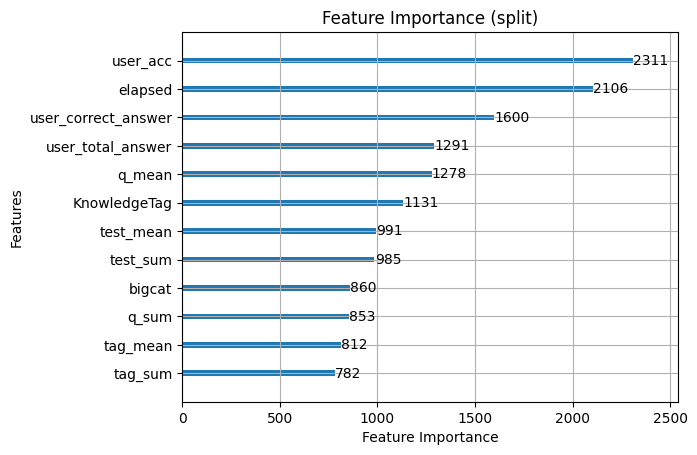

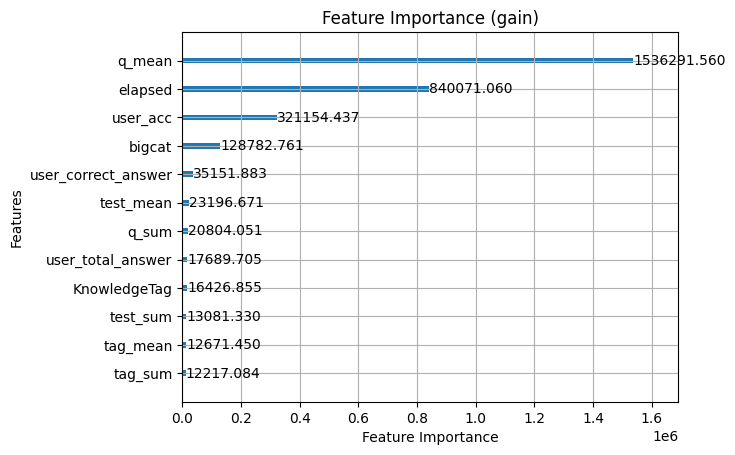

In [125]:
# model: 이미 학습이 완료된 LGBMModel, or Booster
# FEATURES: model 학습에 사용된 모든 features
# PATH: 그림을 저장할 경로

# SPLIT
ax = lgb.plot_importance(model, max_num_features=len(FEATS), importance_type='split')
ax.set(title=f'Feature Importance (split)',
	xlabel='Feature Importance',
	ylabel='Features')
ax.figure.savefig(f'./output/fi_split.png', dpi=300)


# GAIN
ax = lgb.plot_importance(model, max_num_features=len(FEATS), importance_type='gain')
ax.set(title=f'Feature Importance (gain)',
	xlabel='Feature Importance',
	ylabel='Features')
ax.figure.savefig(f'./output/fi_gain).png', dpi=300)